In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu

In [92]:
df_orders  = pd.read_excel('Новый диплом датасет.xlsx', sheet_name = 'Данные')
df_clients = pd.read_excel('Новый диплом датасет.xlsx', sheet_name = 'Clients')
df_reg     = pd.read_excel('Новый диплом датасет.xlsx', sheet_name = 'Region_dict')


In [93]:
df_orders.isnull().any()

id_order       False
id_client       True
amt_payment     True
dtime_pay       True
dtype: bool

In [94]:

df_orders = df_orders[~((df_orders['id_client'].isnull()) | (df_orders['amt_payment'].isnull()) | (df_orders['dtime_pay'].isnull()))]

In [95]:
df_clients.isnull().any()

id_client           False
dtime_ad             True
nflag_test          False
id_trading_point    False
dtype: bool

In [96]:
df_clients['dtime_ad'] = df_clients['dtime_ad'].apply(pd.Timestamp)

In [97]:
df_clients = df_clients[~df_clients['dtime_ad'].isnull()]


In [98]:
df_reg.isnull().any()

id_trading_point    False
city                False
dtype: bool

In [99]:
df_reg_gr = df_reg.groupby('city').count()['id_trading_point'].reset_index().sort_values(by = 'id_trading_point', ascending = False)

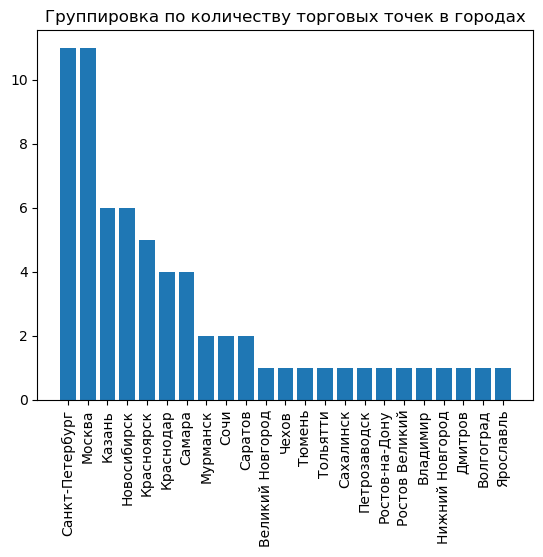

In [100]:
plt.bar(df_reg_gr['city'], df_reg_gr['id_trading_point'])
plt.title('Группировка по количеству торговых точек в городах')
plt.xticks(rotation = 90)
plt.show()

In [101]:

df = df_orders.merge(df_clients, on = 'id_client', how = 'outer')


In [102]:
df = df.merge(df_reg, on = 'id_trading_point')

In [103]:
df['amt_payment'] = df['amt_payment'].fillna(0)

In [104]:
df_cl = df.groupby(['id_client', 'id_trading_point', 'city']).agg({'id_order':'count', 'amt_payment':'sum'}).reset_index()

In [105]:
df_fin = df_cl.merge(df_clients[['id_client', 'dtime_ad', 'nflag_test']], on = 'id_client')

In [106]:

df_fin['flag_paid'] = np.where(df_fin['amt_payment'] > 0, 1, 0)

In [107]:
def test_calc(r1, r2, alpha = 0.05):
    
    s,p = ttest_ind(r1,r2)
    
    if p < alpha:
        print("Гипотеза не подтверждается: средние не равны")
        print("Разница средних = ", r1.mean()-r2.mean())
    else:
        print("Гипотеза подтверждается: средние равны")
        print("Разница средних = 0")
    return s, p

In [108]:
def mann_whitney_func(r1, r2, alpha = 0.5):
    s, p = mannwhitneyu(r1, r2)
    if p<alpha:
        print('Распределения не равны')
    else:
        print('Распределения равны')
    return s, p

In [109]:
zero_payment_points = []

In [110]:
for i in df_fin['id_trading_point'].unique():
    df_loc = df_fin[df_fin['id_trading_point']==i]
    sum_a = df_fin[(df_fin['id_trading_point']==i) & (df_fin['nflag_test']==0)].sum()['amt_payment'].sum()
    sum_b = df_fin[(df_fin['id_trading_point']==i) & (df_fin['nflag_test']==1)].sum()['amt_payment'].sum()
    if(sum_a == 0) | (sum_b == 0):
        zero_payment_points.append(i)
print(zero_payment_points)
        

/var/folders/4c/xjb14cyd5zs6t5tnqttdyjmr0000gn/T/ipykernel_3360/1652371630.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sum_a = df_fin[(df_fin['id_trading_point']==i) & (df_fin['nflag_test']==0)].sum()['amt_payment'].sum()
/var/folders/4c/xjb14cyd5zs6t5tnqttdyjmr0000gn/T/ipykernel_3360/1652371630.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sum_b = df_fin[(df_fin['id_trading_point']==i) & (df_fin['nflag_test']==1)].sum()['amt_payment'].sum()


[26.0, 739.0, 866.0, 46.0, 1099.0, 1015.0, 603.0, 810.0, 800.0, 228.0, 1.0, 13.0, 23.0, 4.0, 7.0]


In [111]:
empty_group_points = []

for i in df_fin['id_trading_point'].unique():
    c_a = df_fin[(df_fin['id_trading_point']==i) & (df_fin['nflag_test']==0)].count()['id_client']
    c_b = df_fin[(df_fin['id_trading_point']==i) & (df_fin['nflag_test']==1)].count()['id_client']
#print(c_a)
#print(c_b)
    if (c_a == 0) | (c_b == 0):
        empty_group_points.append(i)
print(empty_group_points)

[739.0, 866.0, 1099.0, 1015.0, 603.0, 810.0, 800.0, 228.0]


In [112]:
df_fin = df_fin[~df_fin['id_trading_point'].isin(empty_group_points + zero_payment_points)]

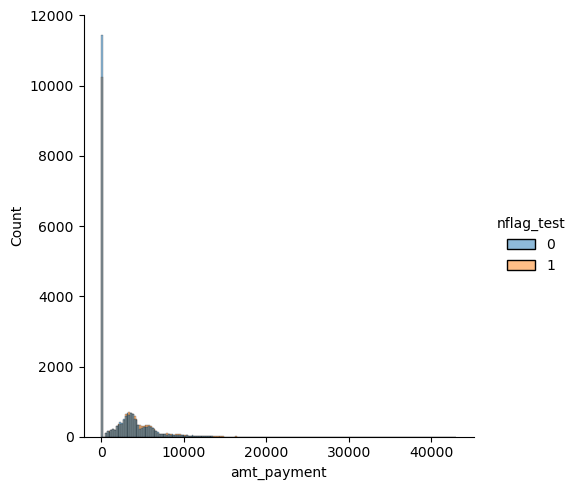

In [113]:
sns.displot(df_fin, x = 'amt_payment', hue = 'nflag_test')

In [114]:
test_calc(df_fin[df_fin['nflag_test']==1]['amt_payment'], df_fin[df_fin['nflag_test']==0]['amt_payment'])

Гипотеза не подтверждается: средние не равны
Разница средних =  263.088912844727


(9.456798235171377, 3.3214645838934018e-21)

In [115]:
test_calc(df_fin[df_fin['nflag_test']==1]['flag_paid'], df_fin[df_fin['nflag_test']==0]['flag_paid'])

Гипотеза не подтверждается: средние не равны
Разница средних =  0.043524040271688325


(9.282032730948323, 1.7338073027564523e-20)

In [116]:
mann_whitney_func(df_fin[df_fin['nflag_test']==1]['amt_payment'], df_fin[df_fin['nflag_test']==0]['amt_payment'])

Распределения не равны


(270040116.0, 3.008345273971901e-24)

In [117]:
all_cities = list(df['city'].unique())

Москва



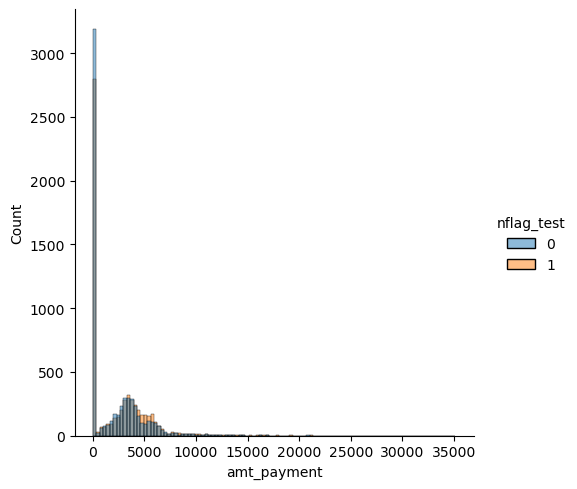

Гипотеза не подтверждается: средние не равны
Разница средних =  -381.7784892750842
Гипотеза не подтверждается: средние не равны
Разница средних =  -0.05557800593933432
Номер торговой точки = 2652.0


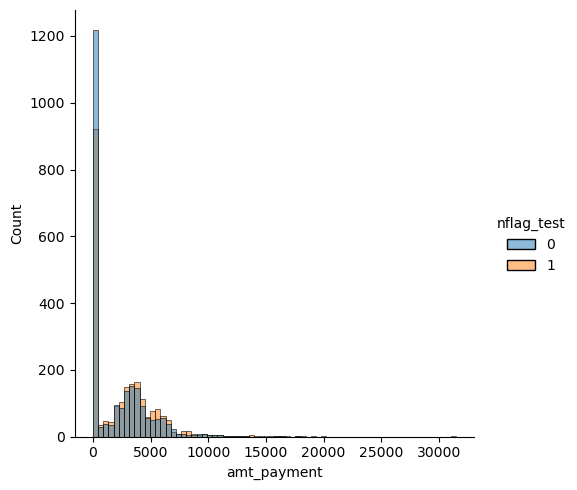

Номер торговой точки = 3786.0


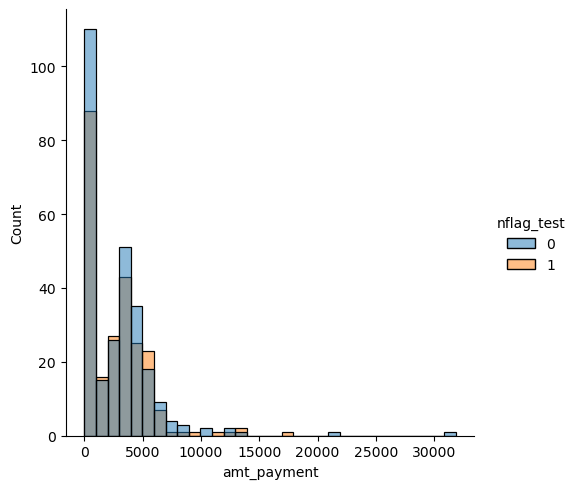

Номер торговой точки = 1287.0


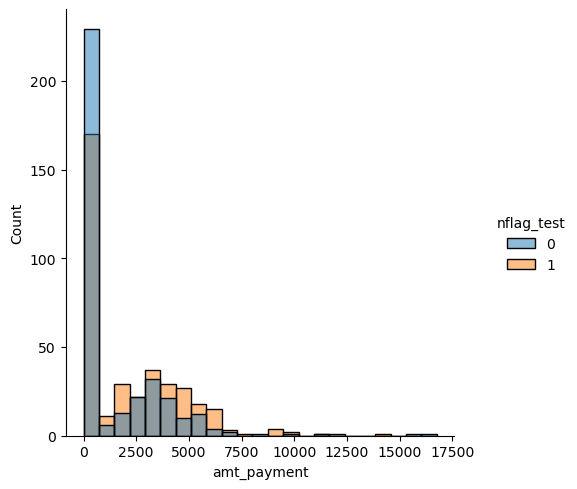

Номер торговой точки = 1654.0


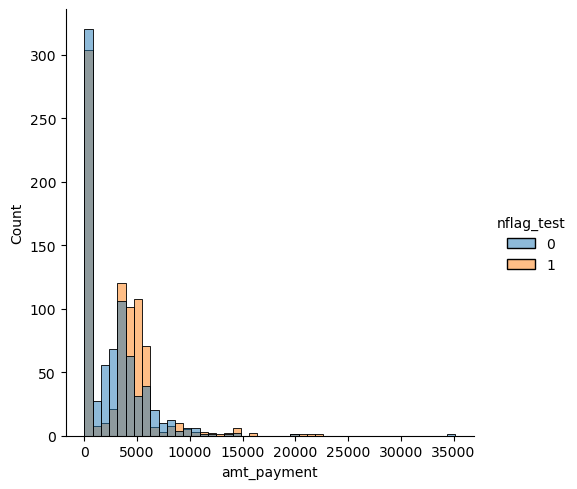

Номер торговой точки = 3987.0


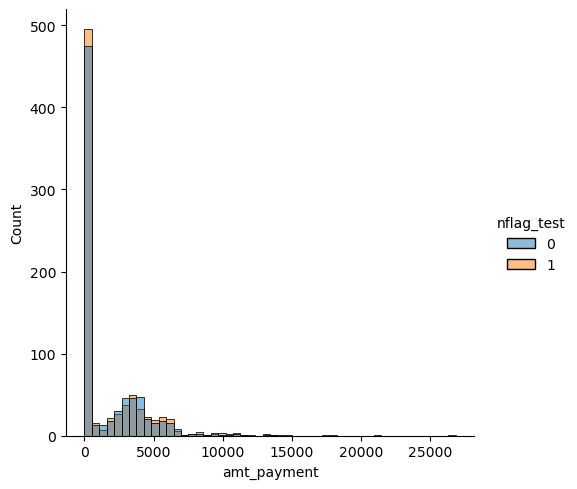

Номер торговой точки = 2212.0


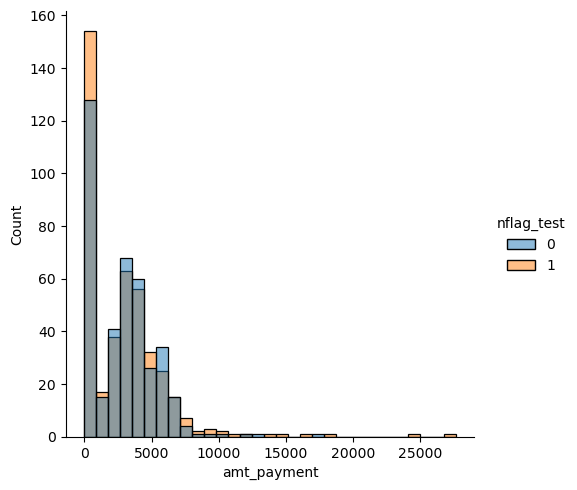

Номер торговой точки = 8543.0


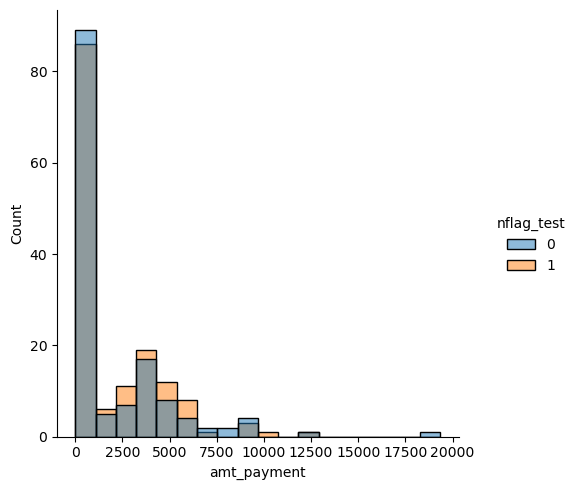

Номер торговой точки = 6543.0


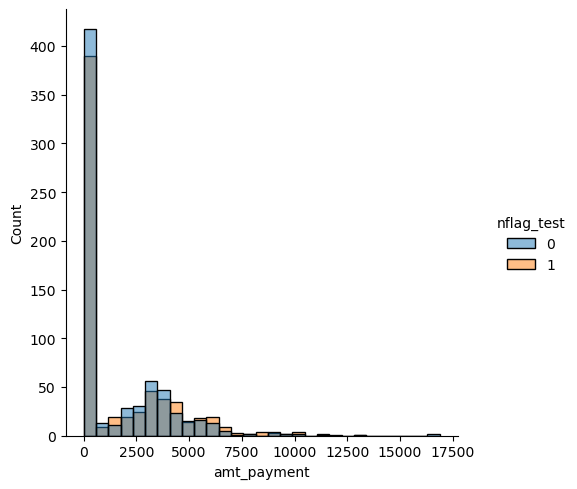

Номер торговой точки = 9121.0


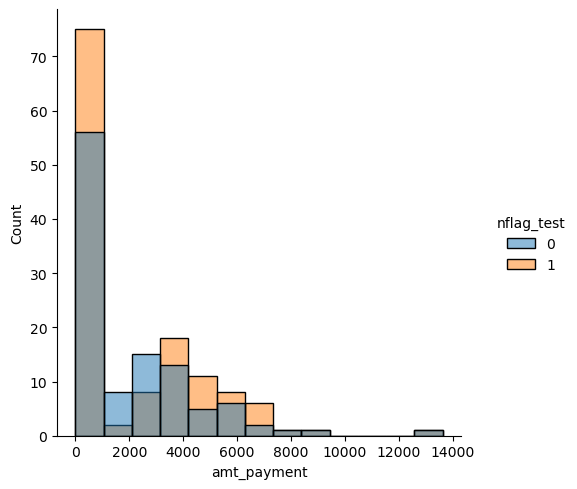

Номер торговой точки = 1002.0


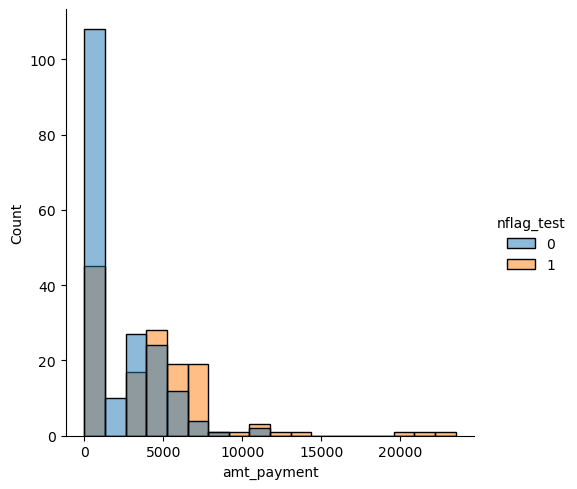

Номер торговой точки = 9931.0


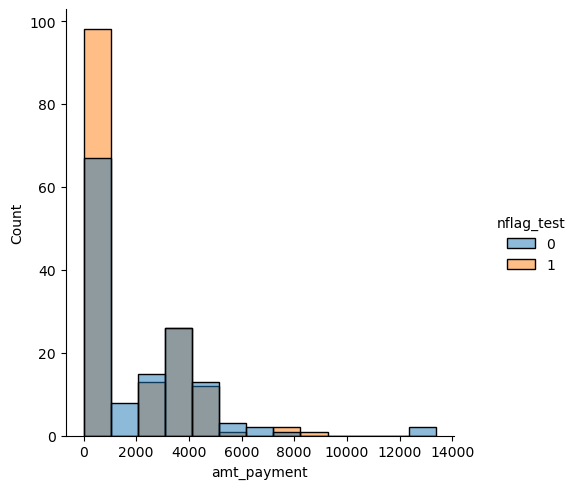

Саратов



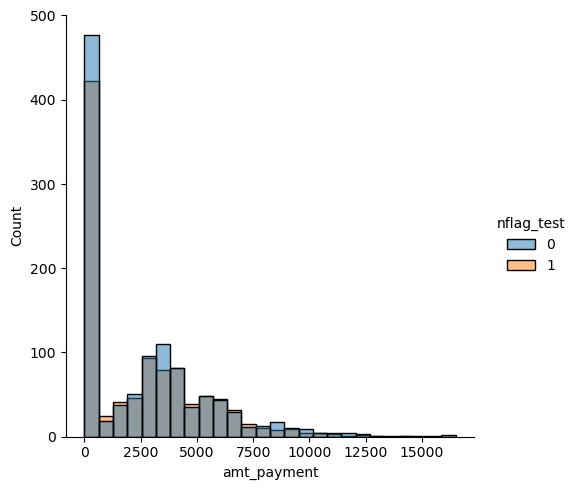

Гипотеза подтверждается: средние равны
Разница средних = 0
Гипотеза подтверждается: средние равны
Разница средних = 0
Номер торговой точки = 80.0


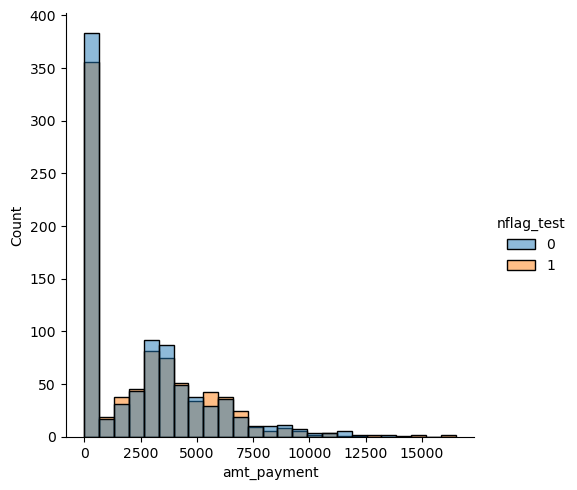

In [ ]:
for i in all_cities:
    print(i)
    print()
    df_city = df_fin[df_fin['city']==i]
    
    sns.displot(df_city, x = 'amt_payment', hue = 'nflag_test')
    plt.show()
    
    test_calc(df_city[df_city['nflag_test']==0]['amt_payment'], df_city[df_city['nflag_test']==1]['amt_payment'])
    test_calc(df_city[df_city['nflag_test']==0]['flag_paid'], df_city[df_city['nflag_test']==1]['flag_paid']) 
    
    for j in df_city['id_trading_point'].unique():
        df_loc = df_city[df_city['id_trading_point']==j]
        print("Номер торговой точки =", j)
        sns.displot(df_loc, x = 'amt_payment', hue = 'nflag_test')
        plt.show()

In [41]:
df_result = pd.DataFrame()
for i in df_fin['city'].unique():
    df_loc = df_fin[df_fin['city']==i]
    
    for j in df_loc['id_trading_point'].unique():
        
        df_loc_f   = df_loc[df_loc['id_trading_point']==j]
        
        count_test    = len(df_loc_f[df_loc_f['nflag_test']==1])
        count_control = len(df_loc_f[df_loc_f['nflag_test']==0])
        count_all     = count_test+count_control
        sigma_test    = df_loc_f[df_loc_f['nflag_test']==1]['amt_payment'].std()
        sigma_control = df_loc_f[df_loc_f['nflag_test']==0]['amt_payment'].std()
        avg_test      = np.mean(df_loc_f[df_loc_f['nflag_test']==1]['amt_payment'])
        avg_control   = np.mean(df_loc_f[df_loc_f['nflag_test']==0]['amt_payment'])
        diff          = avg_test - avg_control
        
        s_a, p_a = test_calc(df_loc_f[df_loc_f['nflag_test']==1]['amt_payment'], df_loc_f[df_loc_f['nflag_test']==0]['amt_payment'])
        s_p, p_p = test_calc(df_loc_f[df_loc_f['nflag_test']==1]['flag_paid'], df_loc_f[df_loc_f['nflag_test']==0]['flag_paid'])
        
        df_result = df_result.append({ 'city':i, 'id_trading_point':j
                                     , 'count_test':count_test, 'count_control':count_control, 'count_all':count_all
                                     , 'avg_test':avg_test, 'avg_control':avg_control
                                     , 'sigma_test':sigma_test, 'sigma_control':sigma_control
                                     , 'diff':diff, 'abs_ttest_s':s_a, 'abs_ttest_p':p_a, 'pr_ttest_s':s_p\
                                                                     }, ignore_index=True)
        

Гипотеза Н0 не подтверждается: средние не равны
Разница средних =  612.0424920007797
Гипотеза Н0 не подтверждается: средние не равны
Разница средних =  0.11967888653001074
Гипотеза Н0 подтверждается: средние равны
Разница средних = 0
Гипотеза Н0 не подтверждается: средние не равны
Разница средних =  0.05984963486602768
Гипотеза Н0 не подтверждается: средние не равны
Разница средних =  531.6059475298125
Гипотеза Н0 не подтверждается: средние не равны
Разница средних =  0.10467325383304943
Гипотеза Н0 подтверждается: средние равны
Разница средних = 0
Гипотеза Н0 подтверждается: средние равны
Разница средних = 0
Гипотеза Н0 подтверждается: средние равны
Разница средних = 0
Гипотеза Н0 подтверждается: средние равны
Разница средних = 0
Гипотеза Н0 не подтверждается: средние не равны
Разница средних =  761.1992559198145
Гипотеза Н0 не подтверждается: средние не равны
Разница средних =  0.14168162121941613
Гипотеза Н0 не подтверждается: средние не равны
Разница средних =  700.0175456389452
Ги

/var/folders/4c/xjb14cyd5zs6t5tnqttdyjmr0000gn/T/ipykernel_3360/611192431.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({ 'city':i, 'id_trading_point':j
/var/folders/4c/xjb14cyd5zs6t5tnqttdyjmr0000gn/T/ipykernel_3360/611192431.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({ 'city':i, 'id_trading_point':j
/var/folders/4c/xjb14cyd5zs6t5tnqttdyjmr0000gn/T/ipykernel_3360/611192431.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({ 'city':i, 'id_trading_point':j
/var/folders/4c/xjb14cyd5zs6t5tnqttdyjmr0000gn/T/ipykernel_3360/611192431.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

Гипотеза Н0 не подтверждается: средние не равны
Разница средних =  2276.966389145853
Гипотеза Н0 не подтверждается: средние не равны
Разница средних =  0.23435090965155725
Гипотеза Н0 не подтверждается: средние не равны
Разница средних =  -552.909116931444
Гипотеза Н0 не подтверждается: средние не равны
Разница средних =  -0.15877105099947525
Гипотеза Н0 подтверждается: средние равны
Разница средних = 0
Гипотеза Н0 подтверждается: средние равны
Разница средних = 0
Гипотеза Н0 подтверждается: средние равны
Разница средних = 0
Гипотеза Н0 подтверждается: средние равны
Разница средних = 0
Гипотеза Н0 подтверждается: средние равны
Разница средних = 0
Гипотеза Н0 подтверждается: средние равны
Разница средних = 0
Гипотеза Н0 не подтверждается: средние не равны
Разница средних =  438.6098419243094
Гипотеза Н0 подтверждается: средние равны
Разница средних = 0
Гипотеза Н0 подтверждается: средние равны
Разница средних = 0
Гипотеза Н0 подтверждается: средние равны
Разница средних = 0
Гипотеза Н0 

/var/folders/4c/xjb14cyd5zs6t5tnqttdyjmr0000gn/T/ipykernel_3360/611192431.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({ 'city':i, 'id_trading_point':j
/var/folders/4c/xjb14cyd5zs6t5tnqttdyjmr0000gn/T/ipykernel_3360/611192431.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({ 'city':i, 'id_trading_point':j
/var/folders/4c/xjb14cyd5zs6t5tnqttdyjmr0000gn/T/ipykernel_3360/611192431.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({ 'city':i, 'id_trading_point':j
/var/folders/4c/xjb14cyd5zs6t5tnqttdyjmr0000gn/T/ipykernel_3360/611192431.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

Гипотеза Н0 подтверждается: средние равны
Разница средних = 0
Гипотеза Н0 подтверждается: средние равны
Разница средних = 0
Гипотеза Н0 подтверждается: средние равны
Разница средних = 0
Гипотеза Н0 подтверждается: средние равны
Разница средних = 0
Гипотеза Н0 не подтверждается: средние не равны
Разница средних =  796.2950869236583
Гипотеза Н0 подтверждается: средние равны
Разница средних = 0
Гипотеза Н0 подтверждается: средние равны
Разница средних = 0
Гипотеза Н0 подтверждается: средние равны
Разница средних = 0
Гипотеза Н0 не подтверждается: средние не равны
Разница средних =  2286.832230686982
Гипотеза Н0 не подтверждается: средние не равны
Разница средних =  0.3436246992782679
Гипотеза Н0 не подтверждается: средние не равны
Разница средних =  1351.8979710144927
Гипотеза Н0 не подтверждается: средние не равны
Разница средних =  0.27831357048748356
Гипотеза Н0 не подтверждается: средние не равны
Разница средних =  1253.3892475190287
Гипотеза Н0 не подтверждается: средние не равны
Раз

/var/folders/4c/xjb14cyd5zs6t5tnqttdyjmr0000gn/T/ipykernel_3360/611192431.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({ 'city':i, 'id_trading_point':j
/var/folders/4c/xjb14cyd5zs6t5tnqttdyjmr0000gn/T/ipykernel_3360/611192431.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({ 'city':i, 'id_trading_point':j
/var/folders/4c/xjb14cyd5zs6t5tnqttdyjmr0000gn/T/ipykernel_3360/611192431.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append({ 'city':i, 'id_trading_point':j
/var/folders/4c/xjb14cyd5zs6t5tnqttdyjmr0000gn/T/ipykernel_3360/611192431.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

In [42]:
df_result

,city,id_trading_point,count_test,count_control,count_all,avg_test,avg_control,sigma_test,sigma_control,diff,abs_ttest_s,abs_ttest_p,pr_ttest_s
0,Санкт-Петербург,453.0,1066,1049,2115,2501.966229,1889.923737,2993.442540,2648.659303,612.042492,4.976910,6.983207e-07,5.541076
1,Санкт-Петербург,112.0,652,683,1335,2488.115031,2218.636896,2778.179183,2780.790660,269.478135,1.770712,7.683710e-02,2.197840
2,Санкт-Петербург,117.0,625,587,1212,2582.297600,2050.691652,2835.004503,2595.737792,531.605948,3.398196,7.003817e-04,3.673055
3,Санкт-Петербург,309.0,240,238,478,2706.279167,2392.894958,2814.939849,2761.938716,313.384209,1.228455,2.198834e-01,1.374431
4,Санкт-Петербург,576.0,630,657,1287,1594.436508,1342.129376,2683.727211,2415.822664,252.307132,1.774073,7.628783e-02,1.535345
5,Санкт-Петербург,900.0,335,341,676,2450.991045,1689.791789,2865.607356,2492.472611,761.199256,3.686914,2.452534e-04,3.718411
6,Санкт-Петербург,213.0,232,255,487,2977.629310,2277.611765,2905.494362,2710.043413,700.017546,2.750752,6.168215e-03,2.524813
7,Санкт-Петербург,801.0,225,212,437,2925.142222,2352.283019,2774.292063,2928.285838,572.859203,2.099991,3.630501e-02,2.475441
8,Санкт-Петербург,573.0,177,160,337,2929.045198,1641.212500,3201.098137,2619.044781,1287.832698,4.016569,7.294074e-05,4.888660
9,Санкт-Петербург,891.0,159,167,326,2618.949686,1980.658683,2899.782464,2489.571942,638.291003,2.135593,3.346204e-02,2.176540


In [43]:
df_result['persent_count'] = (df_result['count_all']/df_result['count_all'].sum())

In [44]:
df_result['nflag_diff'] = np.where((df_result['abs_ttest_p']<0.5) & (df_result['diff']>0), 'Positive'
                                  , np.where((df_result['abs_ttest_p']<0.5) & (df_result['diff']<0), 'Negative', 'No diff'))


In [90]:
writer = pd.ExcelWriter('Калькулятор АБ теста.xlsx', engine='xlsxwriter')

df_result[df_result['nflag_diff']=='Positive'].to_excel(writer, sheet_name='Успешные ТТ', index = False)
df_result[df_result['nflag_diff']=='Negative'].to_excel(writer, sheet_name='Неуспешные ТТ', index = False)
df_result[df_result['nflag_diff']=='No diff'].to_excel(writer, sheet_name='Нет разницы', index = False)

writer.close()